In [1]:
from datasets import load_dataset_builder
from datasets import load_dataset
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

from datasets import ClassLabel, Sequence
from datasets import load_dataset, load_metric
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2LMHeadModel 

import numpy as np
import time

from collections import OrderedDict

from torch_geometric.nn import GCNConv, SimpleConv
from tqdm.auto import tqdm

from torch_geometric.data import Batch

from sklearn.manifold import TSNE

## Helper function

In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
def tokenize_data(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True)

    return tokenized_inputs

## Sentiment Analysis: Load in the IMDb movie Review dataset

In [4]:
dataset = load_dataset("imdb")
dataset

Reusing dataset imdb (/n/home04/yidachen/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Convert text to sequence of tokens

In [5]:
model_checkpoint = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenized_datasets = dataset.map(tokenize_data, batched=True)

{'text': 'This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme\'s acting is awful. He never was much of an actor, but here it is worse.He was definitely better in his earlier movies. His screenplay part for the whole movie was probably not more than one page of stupid nonsense one liners.The whole dialog in the film is a disaster, same as the plot.The title "The Shepherd" makes no sense. Why didn\'t they just call it "Border patrol"? The fighting scenes could have been better, but either they weren\'t able to afford it, or the fighting choreographer was suffering from lack of ideas.This is a cheap low type of action cinema.',
 'label': 0}

## Graph Neural Network

In [7]:
from gcn_probe import GCNProbe, GCNNonlinearProbe, MLPProbe

In [ ]:
np.random.seed(123)

split = "test"
# num_samples = len(tokenized_datasets["test"]) 
num_samples = 1000
train_portion = 0.8

sampled_indices = np.random.choice(np.arange(len(tokenized_datasets[split])),
                                   num_samples, 
                                   replace=False)


sampled_train = np.random.choice(np.arange(len(sampled_indices)), 
                                 int(num_samples * train_portion), 
                                 replace=False)


sampled_test = np.setdiff1d(np.arange(len(sampled_indices)), sampled_train)


train_mask = np.array([True] * num_samples)
train_mask[sampled_test] = False


test_mask = np.array([True] * num_samples)
test_mask[sampled_train] = False

## Constructed GPT-2's internal graph representation of text

In [9]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
        
threshold = 0.2 
    
all_graphs = {}
for layer in range(12):
    all_graphs[layer] = {}
    for head in range(12):
        all_graphs[layer][head] = []
    
# graphs = []

for i in tqdm(sampled_indices):
    features = OrderedDict()
    for name, module in model.named_modules():
        if "c_attn" in name:
            features[name] = ModuleHook(module)


    with torch.no_grad():
        output = model(input_ids = torch.Tensor(tokenized_datasets[split]["input_ids"][i]).type(torch.long).to("cuda"),
                       attention_mask = torch.Tensor(tokenized_datasets[split]["attention_mask"][i]).to("cuda"),
                       output_attentions = True,
                       output_hidden_states = True)


    for feature in features.values():
        feature.close()

    y = tokenized_datasets[split]["label"][i]
    for layer in range(12):
        value_features = features[f'transformer.h.{layer}.attn.c_attn'].features[0].split(768, dim=2)[-1][0].clone()
        for head in range(12):
            weighted_adj_matrix = output["attentions"][layer][0][head].detach().cpu()

            # node_features = output["hidden_states"][layer - 1][0].detach().cpu()

            node_features = value_features[:, head * 64: (head + 1) * 64]

            adj_matrix = weighted_adj_matrix > threshold

            edge_index = adj_matrix.detach().clone().cpu().nonzero().t().contiguous().type(torch.long)
            x = node_features

            data = Data(x=x, edge_index=edge_index, y=y)

            all_graphs[layer][head].append(data)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Convert the dataset to sequence of mini-batch for training

In [10]:
from torch_geometric.loader import DataLoader

train_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]]
test_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[18933, 64], edge_index=[2, 16824], y=[64], batch=[18933], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[18870, 64], edge_index=[2, 17067], y=[64], batch=[18870], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[18970, 64], edge_index=[2, 16928], y=[64], batch=[18970], ptr=[65])

Step 4:
Number of graphs in the current batch: 8
DataBatch(x=[3415, 64], edge_index=[2, 2856], y=[8], batch=[3415], ptr=[9])



## Train and Test Helper functions

In [11]:
def train(model, optimizer, criterion, loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.to("cuda"))  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    return loss
        
        
def test(model, loader):
    model.eval()
    correct = 0
    preds = torch.Tensor([]).to("cuda")
    refs = torch.Tensor([]).to("cuda")
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y.to("cuda")).sum())  # Check against ground-truth labels.
        preds = torch.concat([preds, pred])
        refs = torch.concat([refs, data.y.to("cuda")])
        
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

## Train Probe on Graph representations of Text at 144 Heads

In [12]:
train_accs = {}
test_accs = {}

for layer in tqdm(range(12)):
    train_accs[layer] = {}
    test_accs[layer] = {}
    for head in range(12):
        probe = GCNProbe(64, 2).to("cuda")

        optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        train_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]]
        test_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]]

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        for epoch in range(1, 201):
            loss = train(probe, optimizer, criterion, train_loader)
            train_acc = test(probe, train_loader)

            # if (epoch - 1) % 20 == 0:
            #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            #     print(f'Train Accuracy: {train_acc:.4f}')

        print("-" * 25 + f" layer {layer} head {head} " + "-" * 25)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')
        
        test_acc = test(probe, test_loader)
        print(f'Test Accuracy: {test_acc:.4f}')
        
        train_accs[layer][head] = train_acc
        test_accs[layer][head] = test_acc

  0%|          | 0/12 [00:00<?, ?it/s]

------------------------- layer 0 head 0 -------------------------
Epoch: 200, Loss: 0.4177
Train Accuracy: 0.7375
Test Accuracy: 0.6650
------------------------- layer 0 head 1 -------------------------
Epoch: 200, Loss: 0.4121
Train Accuracy: 0.7700
Test Accuracy: 0.6450
------------------------- layer 0 head 2 -------------------------
Epoch: 200, Loss: 0.4947
Train Accuracy: 0.7738
Test Accuracy: 0.6900
------------------------- layer 0 head 3 -------------------------
Epoch: 200, Loss: 0.4549
Train Accuracy: 0.7488
Test Accuracy: 0.6200
------------------------- layer 0 head 4 -------------------------
Epoch: 200, Loss: 0.4711
Train Accuracy: 0.7750
Test Accuracy: 0.6900
------------------------- layer 0 head 5 -------------------------
Epoch: 200, Loss: 0.6443
Train Accuracy: 0.7600
Test Accuracy: 0.6750
------------------------- layer 0 head 6 -------------------------
Epoch: 200, Loss: 0.4796
Train Accuracy: 0.7900
Test Accuracy: 0.7250
------------------------- layer 0 head 7 

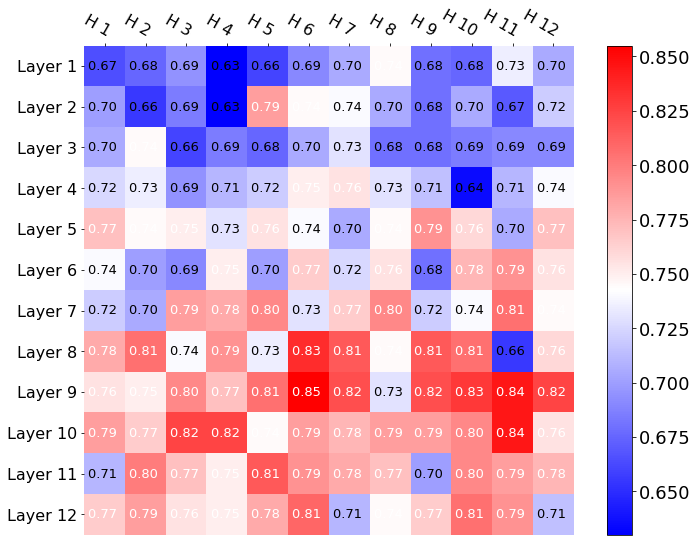

In [29]:
from visualization_utils import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import numpy as np

score_matrix = []

for layer in range(12):
    score_matrix.append([])
    for head in range(12):
        score_matrix[layer].append(test_accs[layer][head])


plt.figure(figsize=(12, 9))

im, cbar = heatmap(np.array(score_matrix), [f"Layer {i + 1}" for i in range(12)], [f"H {i + 1}" for i in range(12)],
        cmap="bwr")

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)

texts = annotate_heatmap(im, valfmt="{x:.2f} ", fontsize=13)

## Few-shot learning

In [10]:
def s_to_i(string_labels, s_to_i_map):
    return [s_to_i_map[string_labels[i]] for i in range(len(string_labels))]


def i_to_s(int_labels, i_to_s_map):
    return [i_to_s_map[int_labels[i]] for i in range(len(int_labels))]


def prompt_input(input_str, examples):
    context_prompt = ""
    
    for example_str, sentiment_label in zip(examples[0], examples[1]):
        example_prompt = f'''### {example_str}\nSentiment (positive or negative): {sentiment_label}\n\n'''
        context_prompt += example_prompt
        
    output_prompt = f'''### {input_str}\nSentiment (positive or negative):'''
    context_prompt += output_prompt
    
    return context_prompt

In [14]:
i_to_s_map = {0: "negative", 1: "positive"}

texts = [dataset["test"]["text"][1], dataset["test"]["text"][19000]]
labels = [dataset["test"]["label"][1], dataset["test"]["label"][19000]]
labels = i_to_s(labels, i_to_s_map)

print(prompt_input(dataset["test"]["text"][6], (texts, labels)))

### Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who the good guys were and weren't. 

In [ ]:
prompted_input = prompt_input(dataset["test"]["text"][20000], (texts, labels))

with torch.no_grad():
    inputs = tokenizer(prompted_input, return_tensors="pt")
    inputs.to("cuda")
    generation_output = model.generate(**inputs, return_dict_in_generate=True, output_scores=True, 
                                       max_length=len(inputs.input_ids[0]) + 1,)

for i, beam in enumerate(generation_output.sequences):
    print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
    print()